### English to Marathi translation

https://towardsdatascience.com/word-level-english-to-marathi-neural-machine-translation-using-seq2seq-encoder-decoder-lstm-model-1a913f2dc4a7

### Datasets
http://www.manythings.org/anki/  (Download and unzip mar-eng.zip file)

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/mydrive')
!ln -s "/content/mydrive/MyDrive" "/gdrive"

Mounted at /content/mydrive


In [5]:
# !wget http://www.manythings.org/anki/hin-eng.zip
# !wget http://www.manythings.org/anki/fra-eng.zip
# !wget http://www.manythings.org/anki/mar-eng.zip
# !unzip mar-eng.zip

!cp /gdrive/NITW/NITW-06-SeqL/mar-eng.zip /content
!unzip /content/mar-eng.zip

Archive:  /content/mar-eng.zip
  inflating: mar.txt                 
  inflating: _about.txt              


In [ ]:
!cp /content/*.zip /gdrive/NITW-SeqLearning/

In [6]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

Using TensorFlow backend.


In [7]:
lines= pd.read_csv('mar.txt' , index_col=None, sep='\t', names=['eng','mar','c'])
lines=lines[['eng','mar']]
#lines.reset_index(drop=True, inplace=True)
print(lines.shape)
lines.head()

(40751, 2)


,eng,mar
0,Go.,जा.
1,Run!,पळ!
2,Run!,धाव!
3,Run!,पळा!
4,Run!,धावा!


In [8]:
# Lowercase all characters
lines.eng=lines.eng.apply(lambda x: x.lower())
lines.mar=lines.mar.apply(lambda x: x.lower())

# Remove quotes
lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x))
lines.mar=lines.mar.apply(lambda x: re.sub("'", '', x))

exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.mar=lines.mar.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
lines.mar = lines.mar.apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
lines.eng=lines.eng.apply(lambda x: x.strip())
lines.mar=lines.mar.apply(lambda x: x.strip())
lines.eng=lines.eng.apply(lambda x: re.sub(" +", " ", x))
lines.mar=lines.mar.apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
lines.mar = lines.mar.apply(lambda x : 'START_ '+ x + ' _END')

In [9]:
lines.sample(10)

,eng,mar
34925,hunting is banned in national parks,START_ राष्ट्रीय उद्यानांमध्ये शिकारीवर बंदी आ...
39530,ive been living in boston since i was thirteen,START_ बॉस्टनमध्ये मी तेरा वर्षांचा असल्यापासू...
37911,tom says he didnt do that for the money,START_ टॉम म्हणतो की त्याने तसं पैश्यासाठी केल...
16598,tom is a psychiatrist,START_ टॉम मानसोपचारज्ञ आहे _END
37342,my train left at six and arrived at ten,START_ माझी ट्रेन सहा वाजता निघाली व दहा वाजता...
9586,ill take the risk,START_ मी ती जोखीम घेईन _END
25210,im very sleepy today too,START_ मलासुद्धा आज खूप झोप आली आहे _END
21245,he extinguished the fire,START_ त्यांनी ती आग विझवली _END
1560,is it for me,START_ माझ्यासाठी आहे _END
6795,wheres my phone,START_ माझा फोन कुठे आहे _END


In [10]:
# Vocabulary of English
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

# Vocabulary of French 
all_marathi_words=set()
for mar in lines.mar:
    for word in mar.split():
        if word not in all_marathi_words:
            all_marathi_words.add(word)

In [11]:
# Max Length of source sequence
# length_list=[]
# for l in lines.eng:
#     length_list.append(len(l.split(' ')))
# max_length_src = np.max(length_list)
# max_length_src


# Max Length of target sequence
# lenght_list=[]
# for l in lines.mar:
#     lenght_list.append(len(l.split(' ')))
# max_length_tar = np.max(lenght_list)
# max_length_tar

length_set =  set()
for l in lines.eng:
    length_set.add(len(l.split(' ')))

length_list = list(length_set)
max_length_src = np.max(length_list)

length_set =  set()
for l in lines.mar:
    length_set.add(len(l.split(' ')))

length_list = list(length_set)
max_length_tar = np.max(length_list)

max_length_src, max_length_tar

(34, 37)

In [12]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_marathi_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_marathi_words)
print(num_encoder_tokens, num_decoder_tokens)
num_decoder_tokens += 1 # For zero padding
num_encoder_tokens += 1 # For zero padding
num_encoder_tokens, num_decoder_tokens

5686 13691


(5687, 13692)

In [13]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [14]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [15]:
lines = shuffle(lines)
lines.head(10)

,eng,mar
20538,tom was in the hospital,START_ टॉम हॉस्पिटलमध्ये होता _END
16534,tom did no such thing,START_ टॉमने असं काहीही केलं नाही _END
28460,she didnt tell me the truth,START_ त्यांनी मला खरं सांगितलं नाही _END
25993,whats the matter now tom,START_ आता काय झालं टॉम _END
5518,dont lie to tom,START_ टॉमशी खोटं बोलू नका _END
18745,we both live in boston,START_ आपण दोघेही बॉस्टनमध्ये राहतो _END
36839,many farmers in hokkaido grow potatoes,START_ होक्काइदोमधील अनेक शेतकरी बटाटे उगवतात ...
35392,what were you doing in my apartment,START_ तू माझ्या फ्लॅटमध्ये काय करत होतीस _END
32116,tom is still asleep in his room,START_ टॉम आपल्या खोलीत अजूनही झोपलेला आहे _END
7351,i covered my ears,START_ मी माझे कान झाकले _END


In [16]:
# Train - Test Split
X, y = lines.eng, lines.mar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((36675,), (4076,))

#### Save the train and test dataframes for reproducing the results later, as they are shuffled.

In [17]:
# X_train.to_pickle('Weights_Mar\X_train.pkl')
# X_test.to_pickle('Weights_Mar\X_test.pkl')
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

In [18]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

### Encoder - Decoder Model Architecture

In [19]:
latent_dim = 50

In [20]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [22]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

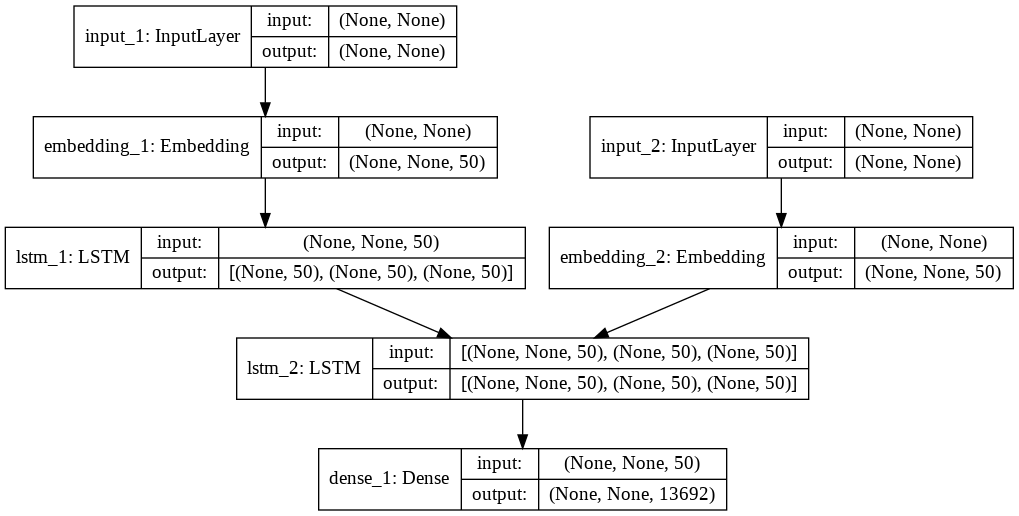

In [ ]:
# from IPython.display import Image
# Image(retina=True, filename='train_model.png')
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [23]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 50

In [ ]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)


Epoch 1/50
286/286 [==============================] - 85s 297ms/step - loss: 0.9815 - acc: 0.1785 - val_loss: 0.8499 - val_acc: 0.1999
Epoch 2/50
286/286 [==============================] - 82s 288ms/step - loss: 0.8499 - acc: 0.2100 - val_loss: 0.7911 - val_acc: 0.2266
Epoch 3/50
286/286 [==============================] - 83s 288ms/step - loss: 0.8079 - acc: 0.2380 - val_loss: 0.7899 - val_acc: 0.2495
Epoch 4/50
286/286 [==============================] - 82s 286ms/step - loss: 0.7743 - acc: 0.2609 - val_loss: 0.7012 - val_acc: 0.2697
Epoch 5/50
286/286 [==============================] - 82s 288ms/step - loss: 0.7406 - acc: 0.2823 - val_loss: 0.6862 - val_acc: 0.2919
Epoch 6/50
286/286 [==============================] - 82s 288ms/step - loss: 0.7117 - acc: 0.3044 - val_loss: 0.7192 - val_acc: 0.3116
Epoch 7/50
286/286 [==============================] - 82s 287ms/step - loss: 0.6872 - acc: 0.3238 - val_loss: 0.7170 - val_acc: 0.3317
Epoch 8/50
286/286 [==============================] - 

### Save the weights

In [ ]:
model.save_weights('/content/nmt_weights_marathi.h5')
!cp /content/nmt_weights_marathi.h5 /gdrive/NITW-SeqLearning/

### Load the weights, if you close the application

In [24]:
!cp /gdrive/NITW/NITW-06-SeqL/nmt_weights_marathi.h5  /content
model.load_weights('nmt_weights_marathi.h5')

AttributeError: ignored

### Inference Setup

In [ ]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the seq, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 


# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

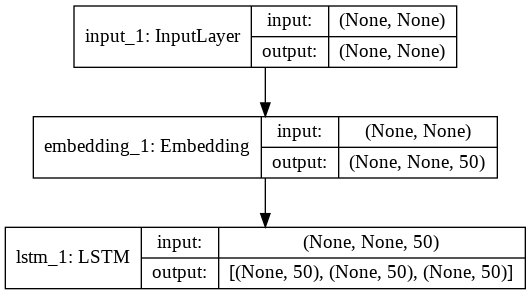

In [ ]:
# Image(retina=True, filename='encoder_model.png')
plot_model(encoder_model, 'modelv.png', show_shapes=True)

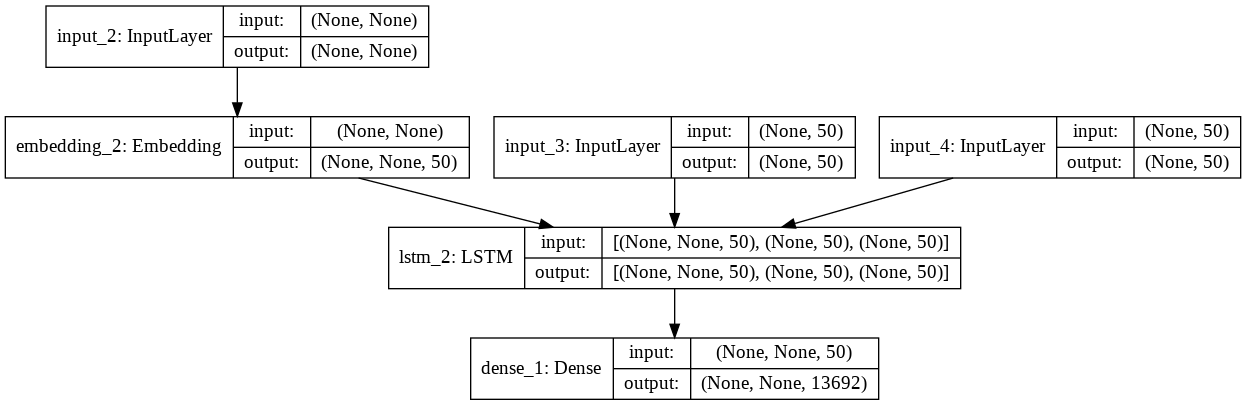

In [ ]:
# Image(retina=True, filename='decoder_model.png')
plot_model(decoder_model, 'modelv.png', show_shapes=True)

### Decode sample sequeces

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

### Evaluation on Train Dataset

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom came to the party last night with mary
Actual Marathi Translation:  टॉम काल रात्री मेरीबरोबर पार्टीला आला होता 
Predicted Marathi Translation:  टॉम काल रात्री रुग्णालयात गेला 


### Evaluation on Validation Dataset

In [ ]:
val_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])